In [14]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as sk
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

(5060, 715)
(5060, 136)
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22']
['01']


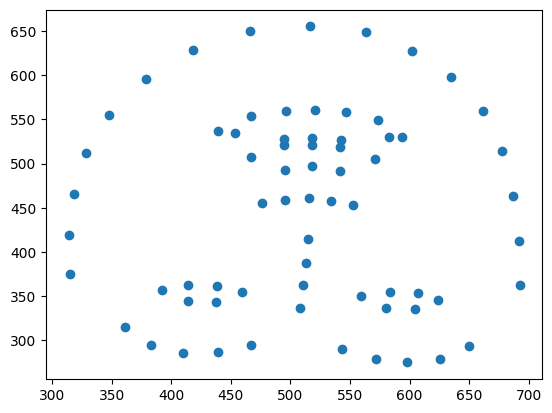

In [3]:
df = pd.read_csv("Database.csv")
print(df.shape)
#au = df.iloc[:, 679:696]
df = df.iloc[:, 299:435]
plt.scatter(df.iloc[0, 0:68], df.iloc[0, 68:136])
df = sk.preprocessing.normalize(df)
df=pd.DataFrame(df)
#df = (df-df.mean())/df.std()
#df = df + au
print(df.shape)
# Read class labels
f = open("labelsDefault.txt", "r")
labels=f.read().splitlines()
labels.pop(0)

# Add y column, which is the target variable
df['y'] = labels
print(df["y"].unique())
# Get dataset only for class 1
dft = df.loc[df['y'] == "01"]
#dft=pd.concat([df.loc[df['y'] == "01"], df.loc[df['y'] == "02"]])
print(dft["y"].unique())

In [4]:
target = torch.tensor(dft['y'].values.astype(np.int_))
data = torch.tensor(dft.drop('y', axis = 1).values.astype(np.float32)) 
df_tensor = torch.utils.data.TensorDataset(data, target)

In [5]:
#Load data into a PyTorch dataset
train_loader = DataLoader(dataset=df_tensor, batch_size=32, shuffle=True)
train_features, train_labels = next(iter(train_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 136])
Labels batch shape: torch.Size([32])


In [6]:
# Creating a PyTorch class
# 18 ==> 3 ==> 18

class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(136, 40),
			torch.nn.Sigmoid(),
			torch.nn.Linear(40, 20),
    		torch.nn.Sigmoid()
		)
		
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(20, 40),
			torch.nn.Sigmoid(),
			torch.nn.Linear(40, 136),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [7]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


In [8]:
epochs = 100
losses = []
writer = SummaryWriter()

for epoch in range(epochs):
    for data in train_loader:
        features, _ = data
        optimizer.zero_grad()
        reconstructed = model(features)
        loss = loss_function(reconstructed, features)
        loss.backward()
        reconstruction_error = torch.mean((reconstructed - features)**2)
        optimizer.step()
        losses.append(loss.item())

    print(f'Epoch: {epoch}, Loss: {loss.item()}')
    print(f'Epoch: {epoch}, Reconstruction error: {reconstruction_error.item()}')
    writer.add_scalar('Loss', loss.item(), epoch)
    writer.add_scalar('Error', reconstruction_error.item(), epoch)



Epoch: 0, Loss: 0.00727105513215065
Epoch: 0, Reconstruction error: 0.00727105513215065
Epoch: 1, Loss: 0.007339127361774445
Epoch: 1, Reconstruction error: 0.007339127361774445
Epoch: 2, Loss: 0.0073462664149701595
Epoch: 2, Reconstruction error: 0.0073462664149701595
Epoch: 3, Loss: 0.007348175160586834
Epoch: 3, Reconstruction error: 0.007348175160586834
Epoch: 4, Loss: 0.007348843850195408
Epoch: 4, Reconstruction error: 0.007348843850195408
Epoch: 5, Loss: 0.0073490752838552
Epoch: 5, Reconstruction error: 0.0073490752838552
Epoch: 6, Loss: 0.007349157240241766
Epoch: 6, Reconstruction error: 0.007349157240241766
Epoch: 7, Loss: 0.007349142339080572
Epoch: 7, Reconstruction error: 0.007349142339080572
Epoch: 8, Loss: 0.00734909949824214
Epoch: 8, Reconstruction error: 0.00734909949824214
Epoch: 9, Loss: 0.007349021267145872
Epoch: 9, Reconstruction error: 0.007349021267145872
Epoch: 10, Loss: 0.007348918821662664
Epoch: 10, Reconstruction error: 0.007348918821662664
Epoch: 11, Los

In [9]:
#Load tensorboard
#tensorboard --logdir=runs
#http://localhost:6006/

#torch.save(model.state_dict(), 'It_just_works')

torch.Size([6, 136])


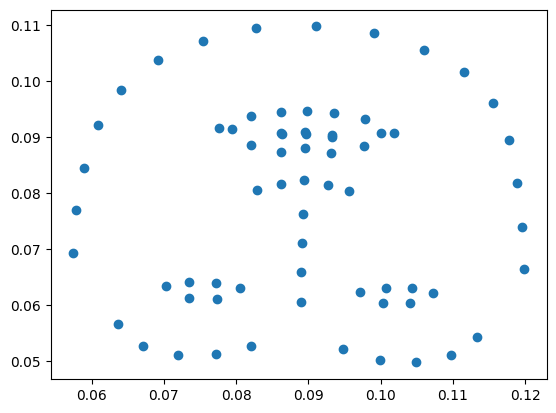

In [10]:
print(data[0].shape)
plt.scatter(data[0][1, 0:68], data[0][1, 68:137])

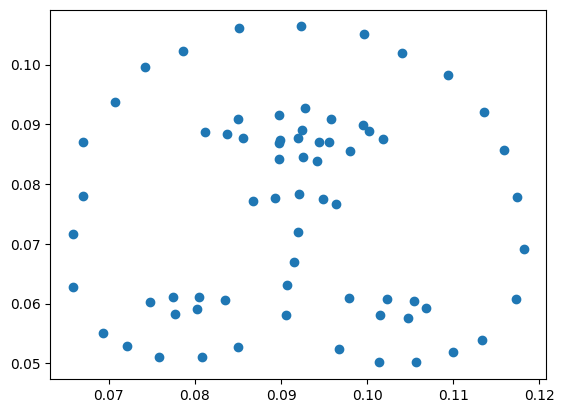

In [11]:
after = model.forward(torch.Tensor(data[0][1, 0:137]))
after = after.detach()
plt.scatter(after[0:68], after[68:137])

In [12]:
models = []

for i in df["y"].unique():
    print(i)
    dft = df.loc[df['y'] == i]
    print(dft["y"].unique())
    target = torch.tensor(dft['y'].values.astype(np.int_))
    data = torch.tensor(dft.drop('y', axis = 1).values.astype(np.float32)) 
    df_tensor = torch.utils.data.TensorDataset(data, target)

    #Load data into a PyTorch dataset
    train_loader = DataLoader(dataset=df_tensor, batch_size=32, shuffle=True)
    train_features, train_labels = next(iter(train_loader))

    #print(f"Feature batch shape: {train_features.size()}")
    #print(f"Labels batch shape: {train_labels.size()}")

    epochs = 100
    losses = []
    writer = SummaryWriter()
    
    # Model Initialization
    model = AE()

    for epoch in range(epochs):
        for data in train_loader:
            features, _ = data
            optimizer.zero_grad()
            reconstructed = model(features)
            loss = loss_function(reconstructed, features)
            loss.backward()
            reconstruction_error = torch.mean((reconstructed - features)**2)
            optimizer.step()
            losses.append(loss.item())

        #print(f'Epoch: {epoch}, Loss: {loss.item()}')
        #print(f'Epoch: {epoch}, Reconstruction error: {reconstruction_error.item()}')
        writer.add_scalar('Loss', loss.item(), epoch)
        writer.add_scalar('Error', reconstruction_error.item(), epoch)
    models.append(model)

print(models)

01
['01']
02
['02']
03
['03']
04
['04']
05
['05']
06
['06']
07
['07']
08
['08']
09
['09']
10
['10']
11
['11']
12
['12']
13
['13']
14
['14']
15
['15']
16
['16']
17
['17']
18
['18']
19
['19']
20
['20']
21
['21']
22
['22']
[AE(
  (encoder): Sequential(
    (0): Linear(in_features=136, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=40, out_features=136, bias=True)
    (3): Sigmoid()
  )
), AE(
  (encoder): Sequential(
    (0): Linear(in_features=136, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=40, out_features=136, bias=True)
    (3): Sigmoid()
  )
), AE(
  (encode

In [21]:
correct = 0
total = 5060
for index, row in tqdm(df.iterrows()):
    min_loss = 100000
    test = torch.Tensor(row[:136])
    result = 23
    for i, model in enumerate(models):
        after = model(test)
        after = after.detach()
        loss = loss_function(after, test)
        if loss < min_loss:
            result = i+1
            min_loss = loss
    if int(row.iloc[136]) == result:
        correct += 1
print(correct, total)
print(correct/total)

5060it [00:24, 202.46it/s]

230 5060
0.045454545454545456
